## Section 1: Estimating model parameters
In this section we're going to define a model that we believe is appropriate for describing our data. We're then going to estimate parameters for this model using a bayesian technique called MCMC.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

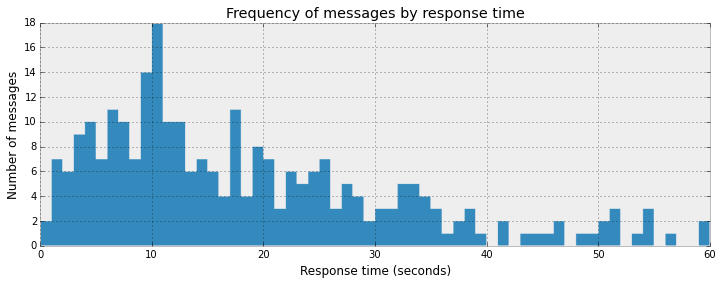

In [5]:
fig = plt.figure(figsize=(12,4))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled')

We first need to choose an appropriate distribution to model the above data. Given that `response_time` is count data, the Poisson distribution would be an appropriate choice. The Poisson distribution takes a parameter $\mu$ which represents both the distribution's mean and its variance. $\mu$ can take any non-negative integer.

### Frequentists method of estimating $\mu$
Before we jump into Bayesian techniques, lets first look at a frequentist method of estimating the parameters of a poisson distribution. We will use an optimization technique that aims to maximize the likelihood of that function.

The below function `poisson_logprob()` returns the overall likelihood of input data points given a poisson model parameter. The input data points are observed and hence cannot be changed. However, the poisson parameter $(\mu)$ can be changed. We use the method `opt.minimize_scalar` to find the value of $\mu$ that is most credible given the data observed.

In [6]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu):
    return -np.sum(stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print "The estimated value of mu is: %s" % np.int(freq_results['x'])

The estimated value of mu is: 18
CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 31.9 µs


So, the estimate of the value of $\mu$ is 18. The optimization technique doesn't provide any measure of uncertinity - it just returns a point value. And it does so very efficiently - the above estimated was returned in 33 µs...

The below plot illustrates the function that we are optimizing. At each value of $\mu$, the plot shows the log probability at $\mu$ given the data and the model.

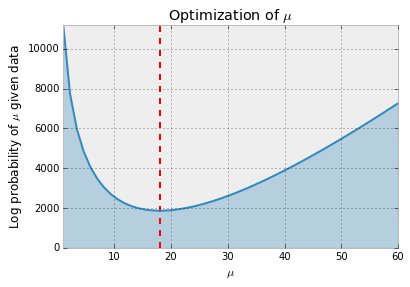

In [7]:
x = np.linspace(1, 60)
y_max = np.max([poisson_logprob(i) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i) for i in x], color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(np.int(freq_results['x']), 0, y_max, colors='red', linestyles='dashed')
_ = plt.ylim(ymin=0, ymax=y_max)
_ = plt.xlim(xmin=1, xmax=60)

So we've estimated $\mu$ of a poisson model to be 18 - but what does that mean and what does it look like. Below you can see a poisson distribution with parameter $\mu$ of 18.

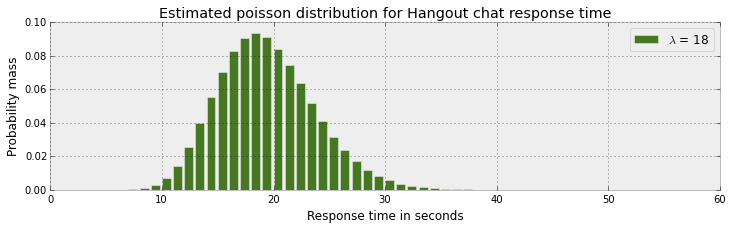

In [8]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

Bayesian techniques have some big advantages (and disadvantages) over the above frequentist technique. We'll explore some of these later. But first, lets estimate the value of $\mu$ by applying a Bayesian estimation technique called MCMC using the pythn library PYMC.

The Bayesian approach to estimating $\mu$ is different than that of Frequentists. To get a fairly detailed intro into the mechanics and theory behind MCMC, I recommend watching the below video by the mathematicalmonk's [Youtube channel](https://www.youtube.com/channel/UCcAtD_VYwcYwVbTdvArsm7w).

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('12eZWG0Z5gY')

### Bayesian method of estimating $\mu$

In [10]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu) # ignore: we will talk about this later
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.6 sec

The below frequency plots represents 20,000 samples drawn from the posterior distribution of $\mu$. The plot on the left can be thought of as a histogram of possible values for $\mu$. The plot on the right shows how the MCMC sampler moved across this distribution sequentially as it pulled 20,000 samples.

The mean of the plot on the left is approximately equal to the estimate of $\mu$ returned by the frequentist method (18 seconds). However, the bayesian approach gives us a measure of undertinity regarding $\mu$. More on this later.

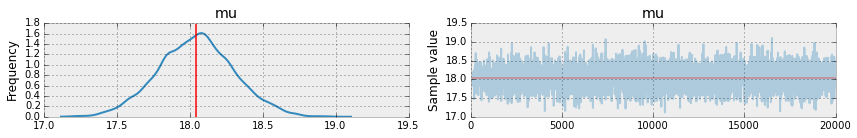

In [11]:
_ = pm.traceplot(trace, vars=['mu'], lines={'mu': freq_results['x']})

### Model convergence
#### Trace
Just because the above model estimated a value for $\mu$, doesn't mean the model estimated a good value given the data. The firs check you should make with estimating parameters using MCMC is the above trace. It should look like a hairy caterpillar as the MCMC sampler jumps around the posterior distribution - tending to stay towards the area of highest likelihood.

#### Autocorrelation plot
TODO: Add comments here

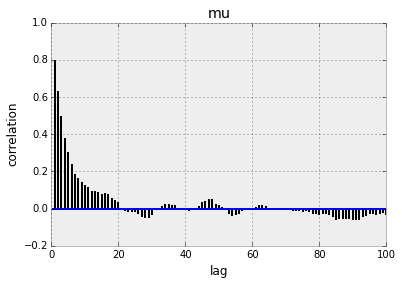

In [12]:
_ = pm.autocorrplot(trace[:2000], vars=['mu'])

In [52]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()